# Packages requis

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime as dt
import folium
from folium import plugins

## In order to use our app
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# Charger mon fichier

In [4]:
#Mon fichier
json_file='./google_data/takeout-20201117T155407Z-003(1)/Takeout/Historique des positions/Historique des positions.json'

In [5]:
# load the google location history data
df_gps = pd.read_json(json_file)
##dimension d'origine
df_gps.shape

(734398, 1)

# Mise en forme du dataset

## Observer la distribution de l'accuracy


In [ ]:
# Observer la distribution de l'accuracy
x = df_gps['locations'].map(lambda x: x['accuracy']).sample(n=25000, random_state=1)
plt.hist(x, bins=200, density = True)
plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim= plt.ylim()
plt.text(x.mean()*2.5, max_ylim*0.9, "Mean: {:.2f}".format(x.mean()), color='red')
plt.axvline(800, color='green', linestyle='dashed', linewidth=1)
plt.text(x.mean()*2.5, max_ylim*0.5, "Cutoff: 800", color='green')
plt.xlabel("Positions accuracy")
plt.yscale('log')
#plt.show()
plt.savefig('histogramme_accuracy.png')

#plt.close()

## Filtrer sur accuracy

In [6]:
# Construire la colonne accuracy
df_gps['accuracy']=df_gps['locations'].map(lambda x: x['accuracy'])
# Supprimer les positions avec une Accuracy > 800
df_gps = df_gps.drop(df_gps[df_gps.accuracy > 800].index)
# Nouvelle dimension
df_gps.shape

(630205, 2)

## Mise en forme de la colonne activité

In [7]:
# Construire la colonne activité
# get activity infered with confidence
df_gps['activity'] = df_gps['locations'].map(lambda x: x['activity'] if 'activity' in x else "NULL" )
# Supprimer les ligne avec une activité NULL 
df_gps = df_gps.drop(df_gps[df_gps.activity == "NULL"].index)
# Nouvelle dimension
df_gps.shape

(308129, 3)

In [8]:
# Remaniement de la colonne activité
tmp_activity = df_gps.activity.map(lambda x: list(map(lambda elt: elt['activity'],x))[0])
df_gps['activity_confidence'] = tmp_activity.map(lambda x: list(map(lambda act: [act['confidence'],act['type']],x)))

In [9]:
# Investigation sur la distribution des activite et de leur confiance
max_confidence_activity = df_gps["activity_confidence"].map(lambda x: max(x, key= lambda y:y[0]))
confidence = map(lambda x: x[0], max_confidence_activity)
activite = map(lambda x: x[1], max_confidence_activity)
d= {'confidence': confidence, 'activity_labels': activite}
df_activite = pd.DataFrame(data=d)
df_activite

,confidence,activity_labels
0,100,TILTING
1,55,STILL
2,69,STILL
3,100,TILTING
4,100,STILL
...,...,...
308124,100,TILTING
308125,100,STILL
308126,100,STILL
308127,100,STILL


## Observer la distribution des effectifs des scores de confiance associés aux activités

In [ ]:
# Visualiser la distribution des effectifs des scores de confiance associés aux activités
g = sns.FacetGrid(df_activite, col="activity_labels", col_wrap=4)
g.map(sns.histplot, "confidence", log_scale=(False,True))
plt.savefig('histogramme_activite.png')

## Filtrer sur l'indice de confiance associé aux activités

In [10]:
df_gps = pd.concat([df_gps.reset_index(drop=True), df_activite.reset_index(drop=True)],axis=1)
# Supprimer lignes avec un score de confiance associé à l'activité inférieur à 50
cutoff = 50

df_gps = df_gps.drop(df_gps[df_gps.confidence < cutoff].index)
# Nouvelle dimension
df_gps.shape

(271872, 6)

## Conversion des coordonnées et de la variable temporelle

In [11]:
# parse lat, lon, and timestamp from the dict inside the locations column
df_gps['lat'] = df_gps['locations'].map(lambda x: x['latitudeE7'])
df_gps['lon'] = df_gps['locations'].map(lambda x: x['longitudeE7'])
df_gps['timestamp_ms'] = df_gps['locations'].map(lambda x: x['timestampMs'])

# convert lat/lon to decimalized degrees 
df_gps['lat'] = df_gps['lat'] / 10.**7
df_gps['lon'] = df_gps['lon'] / 10.**7

#convert the timestamp to date-time
df_gps['timestamp_ms'] = df_gps['timestamp_ms'].astype(float) / 1000
df_gps['datetime'] = df_gps['timestamp_ms'].map(lambda x: dt.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
df_gps['annee'] = df_gps.datetime.map(lambda x: int(x[0:4].strip()))
df_gps['month'] = df_gps.datetime.map(lambda x: int(x[5:7].strip()))
df_gps['day'] = df_gps.datetime.map(lambda x: int(x[8:10].strip()))
df_gps['hour'] = df_gps.datetime.map(lambda x: int(x[11:13].strip()))

## Supprimer les colonnes inutiles

In [12]:
# drop columns we don't need, then show a slice of the dataframe
df_gps = df_gps.drop(labels=['locations','activity' , 'activity_confidence', 'timestamp_ms'], axis=1, inplace=False)
#df_gps[1000:1005]
df_gps.head()

,accuracy,confidence,activity_labels,lat,lon,datetime,annee,month,day,hour
0,30,100,TILTING,45.765414,4.883881,2015-11-23 16:02:10,2015,11,23,16
1,24,55,STILL,45.765359,4.883936,2015-11-23 16:02:56,2015,11,23,16
2,30,69,STILL,45.765420,4.883968,2015-11-23 16:05:27,2015,11,23,16
3,25,100,TILTING,45.765460,4.883908,2015-11-23 16:07:28,2015,11,23,16
4,26,100,STILL,45.765447,4.883906,2015-11-23 16:09:29,2015,11,23,16


# Poids attribués aux positions GPS

Pour la suite, les colonnes ACCURACY et CONFIDENCE pourront nous servir de variable de poids pour le clustering de densité

### Distribution de l'accuracy après filtrage

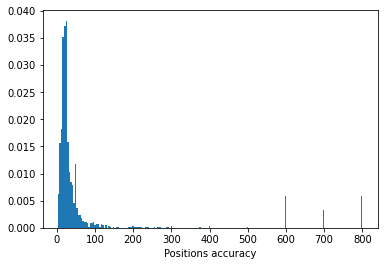

In [14]:
x = df_gps.accuracy.sample(n=25000)

plt.hist(x, bins=200, density = True)
#plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim= plt.ylim()
#plt.text(x.mean()*2.5, max_ylim*0.9, "Mean: {:.2f}".format(x.mean()), color='red')
#plt.axvline(800, color='green', linestyle='dashed', linewidth=1)
#plt.text(x.mean()*2.5, max_ylim*0.5, "Cutoff: 800", color='green')
plt.xlabel("Positions accuracy")
#plt.yscale('log')
plt.show()
#plt.savefig('histogramme_accuracy.png')


### Distribution de l'indice de confiance associé aux activités

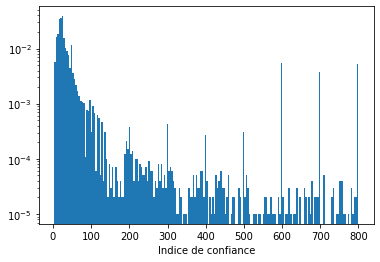

In [45]:
x = df_gps.accuracy.sample(n=25000)
plt.hist(x, bins=200, density = True)
plt.xlabel("Indice de confiance")
plt.yscale('log')
plt.show()
#plt.savefig('histogramme_accuracy.png')

# Normalisation des variables

In [20]:
from sklearn.preprocessing import StandardScaler
x= df_gps[['accuracy', 'confidence']].values
SC = StandardScaler()
SC.fit(x)
xnorm = SC.transform(x)

In [44]:
# Weigth = accuracy_norm * weigth_norm
weight = []
for elt in xnorm:
    weight+=[elt[0]*elt[1]]

# ajout au df
df_gps['weight']=weight

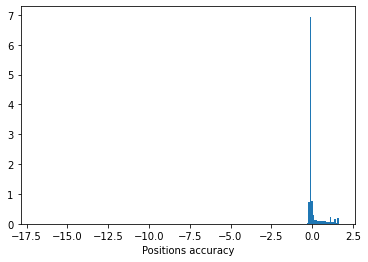

In [42]:
x = weight

plt.hist(x, bins=200, density = True)
#plt.axvline(x.mean(), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim= plt.ylim()
#plt.text(x.mean()*2.5, max_ylim*0.9, "Mean: {:.2f}".format(x.mean()), color='red')
#plt.axvline(800, color='green', linestyle='dashed', linewidth=1)
#plt.text(x.mean()*2.5, max_ylim*0.5, "Cutoff: 800", color='green')
plt.xlabel("Positions accuracy")
#plt.yscale('log')
plt.show()

La distribution est centré réduite

# Folium Heatmap pour visualiser les densités des coordonnées GPS 

## Lors de la première utilisation: initialisation du fichier my_map.html

In [46]:
m = folium.Map([30.8781, -30.6298], zoom_start=2)
# convert to (n, 2) nd-array format for heatmap
coord = df_gps[['lat', 'lon', "weight"]].values
# plot heatmap
heat=plugins.HeatMap(coord, radius=15)
m.add_child(heat,)
m.save('my_map.html')

### Facultatif: réduire la taille du df peut éviter des crashs en fonction des performances de votre machine

In [15]:
df_gps = df_gps.sample(n=100000)

## Application dash

In [49]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from datetime import date
import numpy as np
import folium

app=JupyterDash(__name__)
choice_activity = np.insert(df_gps.activity_labels.unique(), 0, "ALL")
#df_gps
min_date=int(df_gps['annee'].min())
max_date=int(df_gps['annee'].max())

min_hour=int(df_gps['hour'].min())
max_hour=int(df_gps['hour'].max())

app.layout=html.Div([
    html.H1("My map"),
      html.Label(["Select activity to plot", dcc.Dropdown(id="dropdown", 
                                        options = [{"label": x, "value": x} for x in choice_activity],
                                        value=choice_activity[0],
                                        clearable=False)
               ]),
    html.Label(["Select data years from .. to ..", dcc.RangeSlider(
                                            id='year-range-slider',
                                            min= min_date,
                                            max=max_date,
                                            step=1,
                                            value=df_gps['annee'].unique().astype(np.int),
                                            marks={ int(year) : str(year) for year in range(min_date,max_date+1)},
                                            )]),
    html.Label(["Select hours from" , dcc.Dropdown(id="min_hour", 
                                        options = [{"label": f"{hour} H" , "value": hour} for hour in range(min_hour,max_hour+1)],
                                        value=min_hour,
                                        clearable=False)]),
     html.Label([".. to" , dcc.Dropdown(id="max_hour", 
                                        options = [{"label": f"{hour} H" , "value": hour} for hour in range(min_hour,max_hour+1)],
                                        value=max_hour,
                                        clearable=False)]),
    html.Iframe(id='map', srcDoc = open("my_map.html",'r').read(), height= "400", width= "100%"),
    
    html.Div(id = 'df', style={'display':"none"}, children=df_gps.to_json()),
  
])


@app.callback(
    Output('df', 'children'),
    Input('dropdown', 'value'), Input('year-range-slider', 'value'),
    Input('min_hour', 'value'), Input('max_hour', 'value') )
def filter_data(dropdown_value, year_slider_value, min_range_hour, max_range_hour):
    if dropdown_value == choice_activity[0]:
        df = df_gps
    else:
        print("Update Data by activity")
        df = df_gps[df_gps['activity_labels'] == dropdown_value]
        
    max_range_year = max(year_slider_value)
    min_range_year = min(year_slider_value)
    if (min_range_year == min_date) and (max_range_year == max_date):
        dff = df
    else:
        print("Update Data by Year")
        dff = df[(df['annee'] >= min_range_year) & 
                              (df['annee'] <= max_range_year)]
    
    print(min_range_hour)
    print(max_range_hour)
    if (min_range_hour == min_hour) and (max_range_hour == max_hour):
        dfff = dff
    else:
        print("Update Data by Hour")
        dfff = dff[(dff['hour'] >= min_range_hour) & 
                              (dff['hour'] <= max_range_hour)]
        
    print(f"{dfff.shape[0]} coordinates used in map")
    return dfff.to_json()


@app.callback(
    Output('map', 'srcDoc'),
    [Input('df', 'children')])
def update_map(jsonified_cleaned_df):
    #global df = df[df['c'] == value]
    m = folium.Map([30.8781, -30.6298], zoom_start=2)
    # convert to (n, 2) nd-array format for heatmap
    #coord = df_gps[df_gps['activity_labels'] == dropdown]
    dff = pd.read_json(jsonified_cleaned_df)
    coord = dff[['lat', 'lon', "weight"]].values

    # plot heatmap
    heat=plugins.HeatMap(coord, radius=15)
    m.add_child(heat,)
    return m._repr_html_()

app.run_server(mode='inline')

0
23
271872 coordinates used in map
Update Data by activity
0
23
14429 coordinates used in map
Update Data by activity
0
23
6925 coordinates used in map
Update Data by activity
0
23
202380 coordinates used in map
Update Data by activity
0
6
Update Data by Hour
56370 coordinates used in map


## Folium HeatmapTimeSeries pour suivre les habitudes grâce aux coordonnées GPS

In [50]:
#Let's grab only the date and hour by replacing the other parts with 0
df_gps['date_hour'] = df_gps['datetime'].apply(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S').replace(microsecond = 0, second = 0, minute = 0))

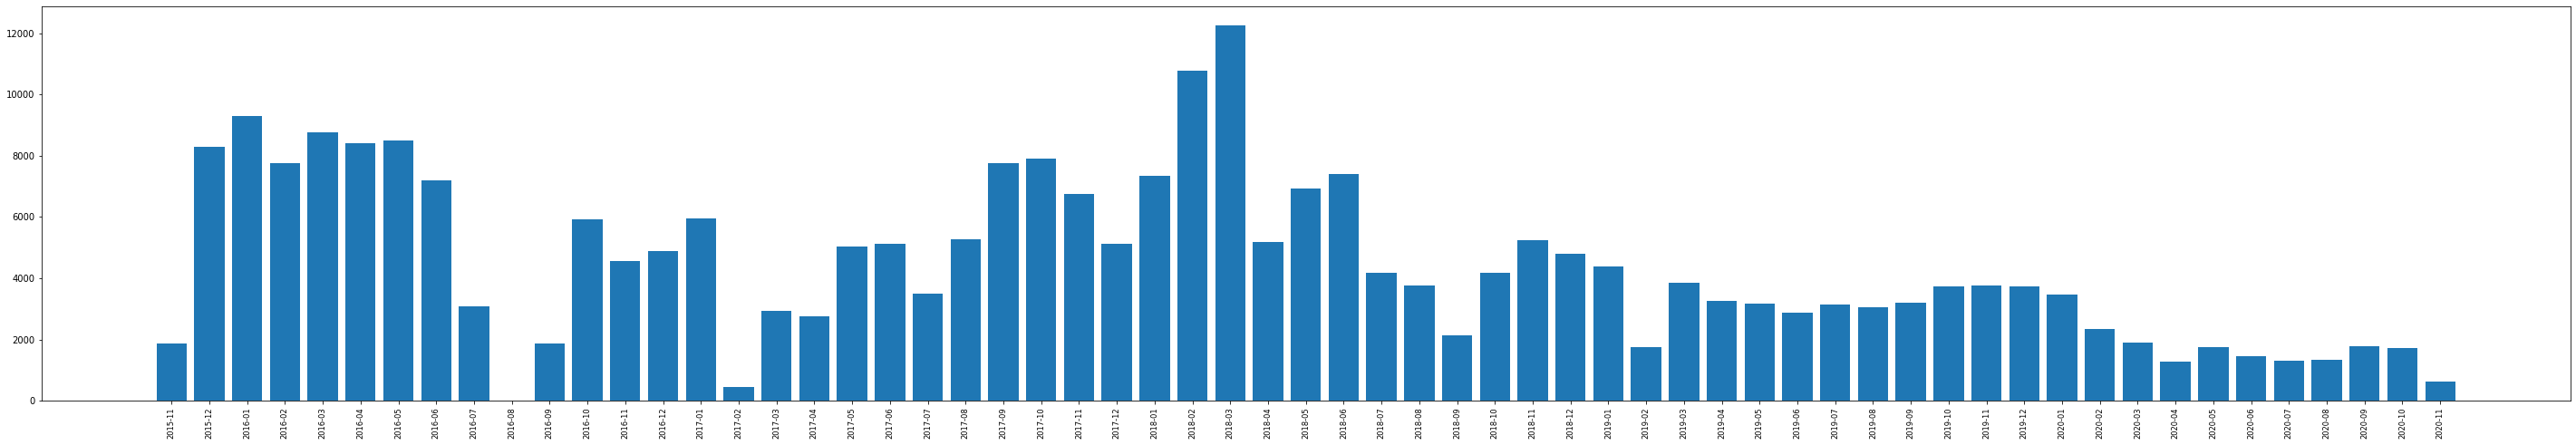

In [52]:
# nombre de position GPS par mois
gps_per_month = df_gps.resample('M', on='date_hour').size().reset_index(name='value')
plt.bar(range(len(gps_per_month)), gps_per_month.value, align='center')
plt.xticks(range(len(gps_per_month)), gps_per_month.date_hour.apply(lambda x:dt.strftime(x,"%Y-%m")), size='small', rotation = 'vertical')
plt.rcParams['figure.figsize'] = [50, 8] ## [largeur, hauteur] à modifier si illisible !
plt.show()
#

In [126]:
#choose a month from a year to follow : integer
month = 10
year = 2016

map_data = df_gps[ (df_gps.day_time >= dt(year,month,1)) & (df_gps.day_time < dt(year,month+1,1))  ]

In [127]:
# build map data
map_data = map_data.groupby("date_hour").apply(lambda x: x[["lat", 'lon', 'accuracy']].values.tolist())
date_hour_index = [x.strftime('%Y-%m-%d %H:%M:%S') for x in map_data.index]
date_hour_data = map_data.tolist()

In [128]:
#Plot map
from folium.plugins import HeatMapWithTime

m_timeSeries = folium.Map([30.8781, -30.6298], zoom_start=2)
hm = HeatMapWithTime(date_hour_data, index = date_hour_index)
hm.add_to(m_timeSeries)
m_timeSeries

# Press play and follow your move 